# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
# Fill in the median and maximum number of user_article interactios below
median_val = df['email'].value_counts()[int(len(df['email'].value_counts())/2)]# 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = df['email'].value_counts()[0] # The maximum number of user-article interactions by any 1 user is ______.
print("median_val: {}, max_views_by_user: {}".format(median_val, max_views_by_user))

median_val: 3, max_views_by_user: 364


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [4]:
# Find and explore duplicate articles
duplicates_count = df_content.article_id.duplicated().sum()
print ("Duplicates found: {}".format(duplicates_count)) # first time = 5: after drop_duplicates = 0

Duplicates found: 5


In [5]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset=['article_id'], keep='first', inplace = True)
duplicates_count = df_content.article_id.duplicated().sum()
assert duplicates_count == 0, "The duplicate count should have dropped to zero, something is wrong."
print ("Duplicates found after removal: {}".format(duplicates_count))

Duplicates found after removal: 0


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [6]:
unique_articles = np.sum(df.groupby('article_id')['article_id'].nunique())# The number of unique articles that have at least one interaction
total_articles = np.sum(df_content['article_id'].value_counts())# The number of unique articles on the IBM platform
unique_users = np.sum(df.groupby('email')['email'].nunique())# The number of unique users
user_article_interactions = df.shape[0]# The number of user-article interactions
print("unique_articles: {}, total_articles: {}, unique_users: {}, user_article_interactions: {}".format(unique_articles, total_articles, unique_users, user_article_interactions))

unique_articles: 714, total_articles: 1051, unique_users: 5148, user_article_interactions: 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [7]:
views_df = df.groupby('article_id').size().reset_index(name='views').sort_values(['views'], ascending=False).head(10)
views_df.head(1)

,article_id,views
699,1429.0,937


In [8]:
most_viewed_article_id = '1429.0'# The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937# The most viewed article in the dataset was viewed how many times?

In [9]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [10]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [11]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_article_ids = get_top_article_ids(n, df)
    
    top_articles = pd.unique(df[df['article_id'].isin(top_article_ids)]['title']).tolist()
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = df.groupby('article_id').size().reset_index(name='views').sort_values(['views'], ascending=False)
    top_articles = np.array(top_articles['article_id'].head(n))
 
    return top_articles # Return the top article ids

In [12]:
print(get_top_article_ids(10))

[ 1429.  1330.  1431.  1427.  1364.  1314.  1293.  1170.  1162.  1304.]


In [13]:
print(get_top_article_ids(10))

[ 1429.  1330.  1431.  1427.  1364.  1314.  1293.  1170.  1162.  1304.]


In [14]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [15]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    user_article = df.groupby(['user_id', 'article_id']).max().unstack().applymap(lambda x: 0 if pd.isnull(x) else 1)
        
    #user_item = np.matrix(user_article)
    user_item = user_article
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [16]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
#assert user_item.sum(axis=1)['1'] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
# As per my comments in https://knowledge.udacity.com/questions/532637 I thihk this assert should be this and not above
assert user_item.loc[[1]].sum(axis=1).item() == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [17]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list of the users in order from most to least similar
    
    '''
    # compute similarity of each user to the provided user
    user_row = user_item.loc[[user_id]]
    predictions = user_row.dot(user_item.transpose())

    # sort by similarity
    most_similar_users = predictions.transpose().sort_values(axis = 0, by = user_id, ascending=False)

    # create list of just the ids
    most_similar_users = most_similar_users.drop(user_id, axis = 1)
   
    # remove the own user's id (which is the first one since that is going to be the best match)
    most_similar_users = most_similar_users.iloc[1: , :]
    most_similar_users = most_similar_users.index.tolist()
       
    return most_similar_users # return a list of the users in order from most to least similar

In [18]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [3933, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [19]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    article_names = df.loc[df['article_id'].isin(article_ids)]['title']
    article_names = np.array(article_names.drop_duplicates(keep='first'))
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    article_ids = user_item.loc[[user_id]].transpose()
    article_ids = article_ids.loc[article_ids[user_id] == 1]
    article_ids = article_ids.index.tolist()
    article_ids = np.array(article_ids)[:,1]

    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    recs = find_similar_users(user_id)[:m]
    
    return recs # return your recommendations for this user_id    

In [20]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [21]:
user_id = 1
user_row = user_item.loc[[user_id]]
predictions = user_row.dot(user_item.transpose())

# sort by similarity
most_similar_users = predictions.transpose().sort_values(axis = 0, by = user_id, ascending=False)
   
# remove the own user's id (which is the first one since that is going to be the best match)
most_similar_users = most_similar_users.iloc[1: , :]

most_similar_users.reset_index(inplace=True)
most_similar_users.rename(columns={'user_id': 'neighbor_id', user_id: 'similarity'}, inplace=True)
most_similar_users['user_id'] = most_similar_users['neighbor_id']
most_similar_users.set_index('user_id', inplace=True)
most_similar_users.head()

user_id,neighbor_id,similarity
user_id,,
3933,3933,35
23,23,17
3782,3782,17
203,203,15
4459,4459,15


In [22]:
interactions = df.groupby('user_id').size().reset_index(name='views').sort_values(['views'], ascending=False).head(10)
user_id = 23 # should be 364 views
#interactions[interactions['user_id'] == user_id]
interactions.set_index('user_id', inplace=True)
interactions.head()

,views
user_id,
23,364
3782,363
98,170
3764,169
203,160


In [23]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Cannot reuse our function from above to get all neighbors since it drops the similirary and 
    # only returns sorterd neighbors, bummer, but we'll just recreate the bits we need here
    user_row = user_item.loc[[user_id]]
    predictions = user_row.dot(user_item.transpose())

    # sort by similarity
    most_similar_users = predictions.transpose().sort_values(axis = 0, by = user_id, ascending=False)
   
    # remove the own user's id (which is the first one since that is going to be the best match)
    most_similar_users = most_similar_users.iloc[1: , :]

    # make the user_id a column as 'neighbor_id' but also make the 'user_id' value as an index to merge (SQL JOIN) with later
    most_similar_users.reset_index(inplace=True)
    most_similar_users.rename(columns={'user_id': 'neighbor_id', user_id: 'similarity'}, inplace=True)
    most_similar_users['user_id'] = most_similar_users['neighbor_id']
    most_similar_users.set_index('user_id', inplace=True)
    
    # user interactions and make the 'user_id' value as an index to use in merge (SQL JOIN)
    interactions = df.groupby('user_id').size().reset_index(name='num_interactions').sort_values(['num_interactions'], ascending=False).head(10)
    interactions.set_index('user_id', inplace=True)
    
    # Now put it all together: 'neighbor_id', 'similarity' with 'num_interactions'
    #concat didn't give us what we needed, need more of a "join" or "vlookup"...neighbors_df = pd.concat([most_similar_users, interactions], axis=1)
    neighbors_df = pd.merge(most_similar_users, interactions, how='left', left_on = 'user_id', right_on = 'user_id')
    
    # Before we sort, let's zero out the NaN values otherwise those bubble to the top, rather see 0 than NaN
    neighbors_df['num_interactions'] = neighbors_df['num_interactions'].replace(np.nan, 0)
    
    # sort the neighbors_df by the similarity and then by number of interactions
    neighbors_df.sort_values(by=['similarity', 'num_interactions'], inplace=True, ascending=False)
    
    return neighbors_df # Return the dataframe specified in the doc_string

def get_user_articles_part2(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Variation of the original get_user_articles but we want a list of the article_ids and article titles 
    that are sorted by article views by user
    '''
    # Your code here
    article_ids = user_item.loc[[user_id]].transpose()
    article_ids = article_ids.loc[article_ids[user_id] == 1]
    
    # HERE is where we differ from the original get_user_articles, we need the number of article views
    # merged here so that we can also sort by views or interactions, after this it's the same as 
    # the original get_user_articles function
    
    # Get article views since we want to choose articles with the most total interactions 
    # before choosing those with fewer total interactions
    views_df = df.groupby('article_id').size().reset_index(name='views').sort_values(['views'], ascending=False)
    article_views_df = pd.merge(article_ids, views_df, how='left', left_on = 'article_id', right_on = 'article_id')
    # sort the article_views_df by the views or interactions
    article_views_df.sort_values(by=['views'], inplace=True, ascending=False)
    article_ids = np.array(article_views_df['article_id'])

    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names

def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    # get_top_sorted_users should already return sorting by similarity and then by number of interactions
    # so the order is already such that we choose the users that have the most total article interactions 
    # before choosing those with fewer article interactions
    neighbors_df = get_top_sorted_users(user_id)
    
    # Track how many articles we have gathered since we want to stop at "m"
    counter = 0
    recs = [] * m
    rec_names = [] * m
    # Loops through the users based on closeness to the input user_id
    for user_id in neighbors_df['neighbor_id']:
        if (counter >= m):
            break;
        # get_user_articles_part2 already gives us ordered articles with the most total interactions
        # before choosing those with fewer total interactions
        article_ids, article_names = get_user_articles_part2(user_id)
        # append only up to stop items as we do not want to exceed m total items
        stop = m - counter
        recs.append(article_ids[:stop])
        rec_names.append(article_names[:stop])
        # Up the counter by the number of records we just appended
        counter += len(recs)
    
    return recs, rec_names

In [24]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[array([ 1429.,  1330.,  1431.,  1364.,  1314.,  1162.,  1436.,  1271.,
        1393.,  1354.]), array([ 1429.,  1330.,  1314.,  1293.,  1162.,  1271.,    43.,  1351.,
        1368.]), array([ 1271.,  1320.,  1328.,  1410.,  1403.,   232.,  1402.]), array([ 1314.,  1436.,  1351.,  1163.])]

The top 10 recommendations for user 20 are the following article names:
[array(['healthcare python streaming application demo',
       'use deep learning for image classification',
       'housing (2015): united states demographic measures',
       'access db2 warehouse on cloud and db2 with python',
       'the nurse assignment problem',
       'predicting churn with the spss random tree algorithm',
       'analyze energy consumption in buildings',
       'visualize car data with brunel',
       'analyze open data sets with pandas dataframes',
       'apache spark lab, part 3: machine learning'], dtype=object), array(['healthcare

`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [25]:
#Running some quick tests to double check our work before we do our dictionary check below
assert 3933 == get_top_sorted_users(1).head(1).iloc[0]['neighbor_id'], "Was expecting 3933 as top neighbor id id for user id 1"
assert 242 == get_top_sorted_users(131).head(10).iloc[9]['neighbor_id'], "Was expecting 242 as top 10th neighbor id for user id 131"
get_top_sorted_users(131).head(1)

,neighbor_id,similarity,num_interactions
user_id,,,
3870,3870,74,0.0


In [26]:
### Tests with a dictionary of results

# NOTE: get_top_sorted_users(1).head(2), returns 3933 as the top match, however, we noticed this user had 0 num_interactions
# this really bothers me as this might be misleading. Maybe we'll sort out later in the exercise.

user1_most_sim = get_top_sorted_users(1).head(1).iloc[0]['neighbor_id']# Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).head(10).iloc[9]['neighbor_id']# Find the 10th most similar user to user 131

In [27]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**I would use get_top_article_ids.** Without knowing a user's preferences we default to the most popular articles.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [28]:
a = get_top_article_ids(10)
b = list(map(str, a))
b[:]

['1429.0',
 '1330.0',
 '1431.0',
 '1427.0',
 '1364.0',
 '1314.0',
 '1293.0',
 '1170.0',
 '1162.0',
 '1304.0']

In [29]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
# *** NOTE: I commented on this in https://knowledge.udacity.com/questions/742232
# the expected assert answer initially failed because it expected a set of string ids not numeric ids which is 
# what get_top_article_ids(10) returns, however, once you cast to a set of string ids it changes the order of 
# the ids. This is confusing. Not sure why the assert was written this way.
new_user_recs = set(map(str, get_top_article_ids(10)))# Your recommendations here

In [30]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

#### How about a Word Cloud?
How about a word cloud of terms used in doc_description or doc_full_name and let's visually pick off the most popular terms we see repeating? Leveraging this code as explained in "Generating WordClouds in Python" by Duong Vu from https://www.datacamp.com/community/tutorials/wordcloud-python.

Then we can use these terms as columns in a matrix, where 1 = term appears in description or full name and 0 where it does not. Then we can do a similar dot product matrix to identify articles that have similar content: 'content_similarity' in much the same way we matched neighbors based on articles viewed similarity.

In [31]:
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


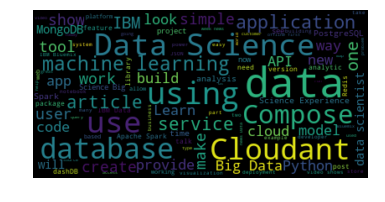

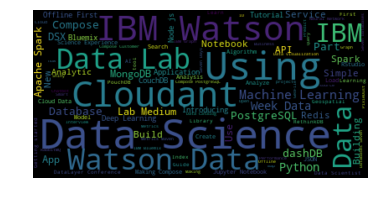

In [32]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# Start with the doc_description
# first run we got an unexpected error: sequence item 354: expected str instance, float found
# Running df_content.dtypes we discover this doc_description is an object and not a string, so need to cast
# cast both to string just in case
doc_description = " ".join(str(review) for review in df_content.doc_description)
doc_full_name = " ".join(str(review) for review in df_content.doc_full_name)

# Create and generate a word cloud image for doc_description
wordclouddesc = WordCloud(max_font_size=50, max_words=100).generate(doc_description)
# Create and generate a word cloud image for doc_full_name
wordcloudfullname = WordCloud(max_font_size=50, max_words=100).generate(doc_full_name)

# Display the generated images
plt.imshow(wordclouddesc, interpolation='bilinear')
plt.axis("off")
plt.show()
plt.imshow(wordcloudfullname, interpolation='bilinear')
plt.axis("off")
plt.show()

We initially settled on the following content keywords (excluding words that are just too common like Using or just Data): 
##### Top 10 from doc_description: 
[ 'database', 'cloudant', 'data science', 'machine learning', 'big data', 'mongodb', 'data scientist', 'tool', 'service', 'ibm' ]
##### Top 10 from doc_full_name (not already in above): 
[ 'python', 'apache', 'spark', 'redis', 'postgresql', 'ibm watson', 'watson', 'data lab', 'api', 'analytic' ]

Hmmm, **but** something seems missing when we did some preliminary tests on this data. Do we have enough df_content per given article_id? Looks like no. See below:

In [33]:
df_content.describe()
df_all = df.merge(df_content, on=['article_id'], 
                   how='left', indicator=True)
print("total: {}, in both: {}, no content: {}, only content: {}, % missing: {:.0%}".format(df_all.shape[0], df_all.loc[df_all['_merge'] == 'both'].shape[0], df_all.loc[df_all['_merge'] == 'left_only'].shape[0], df_all.loc[df_all['_merge'] == 'right_only'].shape[0], df_all.loc[df_all['_merge'] == 'left_only'].shape[0] / df_all.shape[0]))

total: 45993, in both: 21454, no content: 24539, only content: 0, % missing: 53%


53% of the articles do not have content. So let's try the word cloud again but switch to just the title and not the doc_description and doc_full_name...

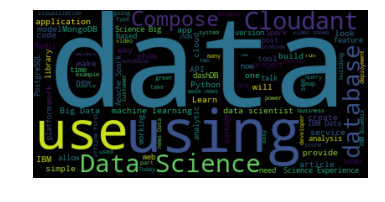

In [34]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# Switch to article title
article_title = " ".join(str(review) for review in df.title)

# Create and generate a word cloud image for article title
wordcloudtitle = WordCloud(max_font_size=150, max_words=100).generate(doc_description)

# Display the generated images
plt.imshow(wordcloudtitle, interpolation='bilinear')
plt.axis("off")
plt.show()

We see similar terms but narrow down to the following content keywords (excluding words that are just too common like Compose, Use, Using, or just Data):

Top 15 from article title:
[ 'database', 'cloudant', 'data science', 'machine learning', 'science experience', 'mongodb', 'application', 'tool', 'service', 'data scientist', 'big data', 'api', 'postgresql', 'analytic', 'learn' ]

So we update our code below accordingly, call it "take 2"

In [35]:
# create the article_content matrix with 1's and 0's
#take 2...doc_description_terms = [ 'database', 'cloudant', 'data science', 'machine learning', 'big data', 'mongodb', 'data scientist', 'tool', 'service', 'ibm' ]
#take 2...doc_full_name_terms = [ 'python', 'apache', 'spark', 'redis', 'postgresql', 'ibm watson', 'watson', 'data lab', 'api', 'analytic' ]
#take 2...content_terms = doc_description_terms + doc_full_name_terms
content_terms = [ 'database', 'cloudant', 'data science', 'machine learning', 'science experience', 'mongodb', 'application', 'tool', 'service', 'data scientist', 'big data', 'api', 'postgresql', 'analytic', 'learn' ]

def create_article_content_matrix(df=df):
    '''
    INPUT:
    df_content - pandas dataframe with article_id, title, and user_id columns
    
    OUTPUT:
    article_content - article content matrix 
    
    Description:
    Return a matrix with article ids as rows and content_terms on the columns with 1 values where an article contains 
    said term in the title and a 0 otherwise
    '''
    # Fill in the function here
    # We just need unique article_id and title and let's keep number of views just in case we need it later to optimize
    article_content = df.groupby(['article_id', 'title']).size().reset_index(name='views').sort_values(['views'], ascending=False)
    
    # Make the title column lower case for comparison
    article_content['title'] = article_content['title'].str.lower()

    # Add a column for each term with a 0 or 1 value
    for term in content_terms:
        # Numpy.where uses | for an OR condition, otherwise you get a weird error: The truth value of a Series is ambiguous 
        #article_content[term] = np.where(article_content['doc_description'].str.contains(term) | article_content['doc_full_name'].str.contains(term), 1, 0)
        article_content[term] = np.where(article_content['title'].str.contains(term), 1, 0)

    # Drop columns we don't need...okay maybe we didn't need views
    article_content = article_content.drop(['title', 'views'], axis = 1)
    
    return article_content # return the article content matrix 

article_content = create_article_content_matrix(df)
article_content.head()

,article_id,database,cloudant,data science,machine learning,science experience,mongodb,application,tool,service,data scientist,big data,api,postgresql,analytic,learn
699,1429.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
625,1330.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
701,1431.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
697,1427.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
652,1364.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Some code below to test out our functions...

In [36]:
user_id = 2
user_article_ids, user_article_names = get_user_articles_part2(user_id)
# compute similarity of each article to the provided user articles
article_rows = article_content.loc[article_content['article_id'].isin(user_article_ids)]
article_rows = article_rows.set_index('article_id')
article_content_index = article_content.set_index('article_id')
predictions = article_rows.dot(article_content_index.transpose())
# to get similatiry add up all the dot products per column and transpose, so you will have a list of 
# articles not already in user_article_ids and we can sort by similarity score or sum of dot products
most_similar_articles = predictions.transpose()
most_similar_articles['similarity'] = most_similar_articles.sum(axis=1)
most_similar_articles = most_similar_articles.sort_values(axis = 0, by = 'similarity', ascending=False)
# get rid of the ones in user_article_ids already
most_similar_articles.reset_index(inplace=True)
most_similar_articles = most_similar_articles[~most_similar_articles.article_id.isin(user_article_ids)]
assert 732 == most_similar_articles.head(1).iloc[0]['article_id'], "Was expecting 732 as top article for this user_id"
most_similar_articles.head()

article_id,article_id,1427.0,1314.0,1305.0,1176.0,1422.0,1024.0,similarity
1,732.0,3,0,0,0,0,1,4
2,120.0,2,0,0,0,0,1,3
3,437.0,2,0,0,0,0,1,3
4,124.0,2,0,0,0,0,1,3
5,412.0,2,0,0,0,0,1,3


The code below is where we first noticed there was missing content data. So let's try this check again, for a given user make sure we find the corresponding rows on the article_content matrix now. Before for user_id 2, of the 6 articles that user had interacted with only 1 appeared on df_content. Let's try user_id again...

In [37]:
user_id = 2
user_article_ids, user_article_names = get_user_articles_part2(user_id)
print(user_article_ids)
#user_article_ids = [1427,1314,1305,1176,1422,1024]
####df_content only covers 53% of the articles...take 2...user_matrix = df_content.loc[df_content['article_id'].isin(user_article_ids)]
user_article_ids, user_article_names = get_user_articles_part2(user_id)
#user_matrix = article_content.loc[article_content['article_id'].isin(user_article_ids)]
user_matrix = article_content.loc[article_content['article_id'].isin(user_article_ids)]
assert 1427 == user_matrix.head(1).iloc[0]['article_id'], "Was expecting 1427 as top article for this user_id"
user_matrix.head(len(user_article_ids))

[ 1427.  1314.  1305.  1176.  1422.  1024.]


,article_id,database,cloudant,data science,machine learning,science experience,mongodb,application,tool,service,data scientist,big data,api,postgresql,analytic,learn
697,1427.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
614,1314.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
609,1305.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
532,1176.0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
692,1422.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
425,1024.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


Okay, better. We find all the user articles as expected. Let's proceed with this version of the article_content matrix.

In [38]:
def make_content_recs(user_id, articles_i_like=[], m=10, article_content=article_content):
    '''
    INPUT:
    user_id - (int) a user id
    articles_i_like - (array or list) article ids a user has liked, this is for the case where the user does not
                    show up as interacting with any articles
    m - (int) the number of recommendations you want for the user
    article_content - (matrix) the article content matrix 
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Get the user
    
    Notes:
    * Allows the caller to pass either a non-zero user_id or a list of articles they like for new users
    or users that do not have any interactions yet
    
    '''
    # compute similarity of each user article to the other articles in the article_content matrix
    # get the matrix representing the articles for this user_id *or* use the given articles (e.g. a new user)
    if user_id == 0 or len(articles_i_like) > 0:
        user_article_ids = articles_i_like
        user_article_names = get_article_names(user_article_ids)
    else:
        user_article_ids, user_article_names = get_user_articles_part2(user_id)
    # compute similarity of each article to the provided user articles
    article_rows = article_content.loc[article_content['article_id'].isin(user_article_ids)]
    article_rows = article_rows.set_index('article_id')
    article_content_index = article_content.set_index('article_id')
    predictions = article_rows.dot(article_content_index.transpose())
    
    # to get similatiry add up all the dot products per column and transpose, so you will have a list of 
    # articles not already in user_article_ids and we can sort by similarity score or sum of dot products
    most_similar_articles = predictions.transpose()
    most_similar_articles['similarity'] = most_similar_articles.sum(axis=1)
    most_similar_articles = most_similar_articles.sort_values(axis = 0, by = 'similarity', ascending=False)
    
    # get rid of the ones in user_article_ids already
    most_similar_articles.reset_index(inplace=True)
    most_similar_articles = most_similar_articles[~most_similar_articles.article_id.isin(user_article_ids)]

    # create list of just the ids
    recs = most_similar_articles['article_id'].head(m).tolist()
    rec_names = get_article_names(recs)
    
    return recs, rec_names # return a list of the users in order from most to least similar
# test existing user
print(make_content_recs(2))
# test user with no interactions recorded but a user who likes a given set of articles
print(make_content_recs(0, [723.0]))

([732.0, 120.0, 437.0, 124.0, 412.0, 1297.0, 721.0, 500.0, 723.0, 250.0], array(['python machine learning: scikit-learn tutorial',
       'rapidly build machine learning flows with dsx',
       'ibm watson machine learning: get started',
       'adoption of machine learning to software failure prediction',
       '10 essential algorithms for machine learning engineers',
       'a dynamic duo – inside machine learning – medium',
       'the power of machine learning in spark',
       'the difference between ai, machine learning, and deep learning?',
       'building your first machine learning system ',
       'from local spark mllib model to cloud with watson machine learning'], dtype=object))
([195.0, 26.0, 809.0, 500.0, 250.0, 871.0, 1297.0, 833.0, 732.0, 260.0], array(['overfitting in machine learning: what it is and how to prevent it',
       'rapidly build machine learning flows with dsx',
       'use the machine learning library',
       'machine learning and the science of choos

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

#### How I would improve the content based recommendation system? 
We can develop a way to test the effectiveness of the words we have chosen to test for. Perhaps 15 is not nearly enough terms, maybe it should be closer to 150 terms. We can test this by gathering words not based on a word cloud but programmatically grab the top 150 words or vary the number of words/terms then iterate across each set, e.g. test the original 15 then compare to adding the next 10 terms, etc. until we see diminishing returns because we may end up with words that are too common to make any difference. But that way we can narrow down the number of terms to use to see how well we perform based on a known set of data. I also thought about splitting up the data into a learning set and a test set, however, that is not necessarily comparing apples to apples as we are not necessarily testing the results of our recommendations but the views other users have selected.

#### Other options with this same approach
What we built here is **Content Based**, so more like "based on something you interacted with or based on what you say you like, I can recommend other similar ones based on content." However, we could simply provide our list of 15 terms or so like a list of radio box options where you can say something like "I don't know exactly what article I want but give something on 'machine learning' and 'watson' or 'deep learning', etc." Same concept but different approach more like a **Knowledge Based** approach.

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

In [39]:
# make recommendations for a brand new user...same as before just return the top articles
print (get_top_article_ids(10))

# But then we can immediately make more recommendations as soon as they interact with their first, then second article, etc.

# make recommendations for a user who only has interacted with article id '1427.0'
print(make_content_recs(0, [1427.0]))

[ 1429.  1330.  1431.  1427.  1364.  1314.  1293.  1170.  1162.  1304.]
([732.0, 124.0, 784.0, 412.0, 437.0, 284.0, 74.0, 40.0, 89.0, 260.0], array(['python machine learning: scikit-learn tutorial',
       'rapidly build machine learning flows with dsx',
       'ibm watson machine learning: get started',
       'the 3 kinds of context: machine learning and the art of the frame',
       'adoption of machine learning to software failure prediction',
       'ensemble learning to improve machine learning results',
       'the machine learning database',
       'top 20 r machine learning and data science packages',
       'apache spark 2.0: machine learning. under the hood and over the rainbow.',
       '10 data science, machine learning and ai podcasts you must listen to'], dtype=object))


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, we will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [51]:
#NOTE: The user_item_matrix.p pickle file exceeds the 25M limit on GitHub files right now on my account
#So we'll just reuse the user_matrix we built above
# Load the matrix here
#user_item_matrix = pd.read_pickle('user_item_matrix.p')
user_item_matrix = user_item

In [43]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [46]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix)# use the built in to get the three matrices
s.shape, u.shape, vt.shape

((714,), (5149, 5149), (714, 714))

**Provide your response here.**
This user item matrix data is different from the lesson in just sheer size alone. We have a **LOT MORE** potential latent factors with this data: 5,149, whereas our SVC lesson it was a much smaller data set, only 20. Meaning right now our U matrix is square with 5,149 articles. In the lesson we were looking at 4 users and 20 latent features.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

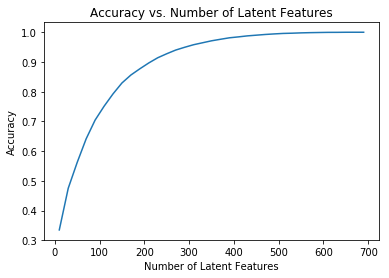

In [47]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [48]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # a user-item matrix of the training dataframe
    user_item_train = df_train.groupby(['user_id', 'article_id']).max().unstack().applymap(lambda x: 0 if pd.isnull(x) else 1)
    
    # a user-item matrix of the testing dataframe 
    user_item_test = df_test.groupby(['user_id', 'article_id']).max().unstack().applymap(lambda x: 0 if pd.isnull(x) else 1)
    
    # Build an array of all the unique user_ids in df_test
    test_idx = np.array(df_test.user_id.unique())
    
    # Build an array of all the unique article_ids in df_test
    test_arts = np.array(df_test.article_id.unique())
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

df_train_user_id = user_item_train.reset_index()
df_train_article_id = user_item_train.drop('title', axis = 1).melt()

print("users in the test set: {}, users in test but not in train: {}".format(len(test_idx), df_train_user_id[~df_train_user_id.user_id.isin(test_idx)].shape[0]))
print("articles in the test set: {}, articles in test but not in train: {}".format(len(test_arts), df_train_article_id[~df_train_article_id.value.isin(test_arts)].shape[0]))

users in the test set: 682, users in test but not in train: 4467
articles in the test set: 574, articles in test but not in train: 0


In [49]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d,
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


If you see an error above like:

>KeyError: 'How many movies can we make predictions for in the test set?'

It is because there seems to be an error in the included test code. Possibly a copy/paste error because it was checking for 'How many movies can we make predictions for in the test set?' rather than 'How many articles can we make predictions for in the test set?' We submitted feedback on this. Let's move on.

`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [50]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)# use the built in to get the three matrices
u_train.shape, s_train.shape, vt_train.shape # fit svd similar to above then use the cells below

((4487, 4487), (714,), (714, 714))

In [ ]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])